In [11]:
# %% 
"""
Note: I need to import the data from parameters.py
"""
import geopandas as gpd
import numpy as np
import pandas as pd
import itertools
import pyomo.environ as pyo
import matplotlib.pyplot as plt
from parameters import dps, hfs, hps, hcs, services, health_workers, levels, HFs_to_locate, distance_matrix, workers_to_allocate, lb_workers, a_HF, a_W, t1max, service_time, working_hours
from parameters import demand_points_gdf, hfs_gdf
from parameters import total_population, dr_oh, dr_ch, dd_oh, dd_ch #new Feb 19

In [ ]:
# Define the sets and parameters
I = dps
J = hfs
J_HP = hps
J_HC = hcs
t = distance_matrix # travel time (distances) between demand points and HFs
S = services
P = health_workers
L = levels
n_HF = dict(zip(levels, HFs_to_locate))
n_W = dict(zip(health_workers, workers_to_allocate))
#d1 = dd_oh
#d2 = dd_ch
Pi = total_population #new Feb 19
r1 = dr_oh #new Feb 19
r2 = dr_ch #new Feb 19
d1 = dd_oh #new Feb 19; either this is necessary, or Pi and r1
d2 = dd_ch #new Feb 19; either this is necessary, or Pi and r2
lb = lb_workers
q = dict(zip(services, service_time))
c = dict(zip(health_workers, working_hours))
#S_l = {l: {s for s in S if a_HF.get((s, l), 0) == 1} for l in L}

total_sum = sum(dd_oh.values())
print(total_sum)

960


In [6]:
def model_mshlam_feb25(I, J, J_HP, J_HC, S, P, L, n_HF, Pi, r1, r2, d1, d2, t, n_W, lb, a_HF, a_W, t1max, q, c):
    """
    Inputs:
    
        I (array): (indices of) demand points; eg, ['i1',...,'i16']
        J (array): (indices of) candidate locations for HFs; eg, ['j1',...,'j9']
        J_HP (array): (indices of) candidate locations for HPs; eg, ['j2','j3','j4','j6','j7','j8']
        J_HC (array): (indices of) candidate locations for HCs; eg, ['j1','j3','j4','j5','j9']
        S (array): (indices of) types of services; eg, ['basic','maternal1','maternal2']
        P (array): (indices of) types of health workers; eg, ['doctor','nurse','midwife']
        L (array): (indices of) levels of HFs; eg, ['hp','hc']
    
        n_HF (dict): per l in L, the number of HF of level l to locate

        Pi (dict): per i in I, the total population at zone i 
        r1 (dict): pero i in I and s in S, the daily demand rate from i for service s during HP's opening times
        r2 (dict): per i in I and s in S, the daily demand rate from i for service s outside of HP's opening times 
        d1 (dict): per i in I and s in S, the number of people from i daily demanding service s during HP's opening times (it is Pi[i]*r1[i,s])
        d2 (dict): per i in I and s in S, the number of people from i daily demanding service s outside of HP's opening times (it is Pi[i]*r2[i,s])
        
        t (DataFrame): travel times (distances) between pairs of location nodes, ie, between pairs in {I, J_HP, J_JC}   
        n_W (dict): per p in P, the number of health workers of type p to locate
        lb (dict): per p in P and l in L, the minimum number of health workers of type p that need to be present at an open HF of level l
        a_HF (dict): per s in S and l in L, boolean operator indicating whether service s can be provided at a HF of level l (1) or not (0)
        a_W (dict): per p in P and s in S, boolean operator indicating whether health worker type p is able to deliver service s (1) or not (0)
        t1max (integer): maximum/coverage travel time (distance) from a demand point to the HF that is its first assignment
        q (dict): per s in S, the service time for s
        c (dict): per p in P, the number of daily working hours for health worker of type p
        
        
    
    Returns: m
        
    """

    
    m = pyo.ConcreteModel('MSHLAM')
    
    # Function to remove all components from the model
    def remove_all_components(m):
        components = list(m.component_objects())
        for comp in components:
            m.del_component(comp)
    
    # Remove all components from the model
    remove_all_components(m)
    
    m.I = pyo.Set(initialize=I)
    m.J = pyo.Set(initialize=J)
    m.J_HP = pyo.Set(initialize=J_HP)
    m.J_HC = pyo.Set(initialize=J_HC)
     
    
    m.S = pyo.Set(initialize=S)
    m.P = pyo.Set(initialize=P)
    m.L = pyo.Set(initialize=L)
    
    m.n_HF = pyo.Param(m.L, initialize=n_HF, within=pyo.Integers)


    m.Pi = pyo.Param(m.I, initialize=Pi, within=pyo.NonNegativeIntegers)
    m.r1 = pyo.Param(m.I, m.S, initialize=r1, within=pyo.NonNegativeReals)
    m.r2 = pyo.Param(m.I, m.S, initialize=r2, within=pyo.NonNegativeReals)
    m.d1 = pyo.Param(m.I, m.S, initialize=d1, within=pyo.NonNegativeReals)
    m.d2 = pyo.Param(m.I, m.S, initialize=d2, within=pyo.NonNegativeReals)
    
    m.t = pyo.Param(m.I, m.J, initialize={(i, j): t.loc[i, j] for i in t.index for j in t.columns})
    
    m.n_W = pyo.Param(m.P, initialize=n_W, within=pyo.Integers)
    m.lb = pyo.Param(m.P, m.L, initialize=lb, within=pyo.Integers)
    #Todo: I think a_l makes more sence
    m.a_HF = pyo.Param(m.S, m.L, initialize=a_HF, within=pyo.Binary)
    m.a_W = pyo.Param(m.P, m.S, initialize=a_W, within=pyo.Binary)
    
    m.t_max = pyo.Param(initialize=t1max, within=pyo.NonNegativeReals) #Not sure if I need to do this, as it is just a constant
    
    m.q = pyo.Param(m.S, initialize=q, within=pyo.NonNegativeReals)
    m.c = pyo.Param(m.P, initialize=c, within=pyo.NonNegativeReals)
    
    # Variables:
    m.y = pyo.Var(m.J, m.L, within=pyo.Binary)
    m.x1 = pyo.Var(m.I, m.J, within=pyo.Binary)
    m.x2 = pyo.Var(m.I, m.J, within=pyo.Binary)
    m.f1 = pyo.Var(m.I, m.J, m.S, within=pyo.NonNegativeIntegers)
    m.f2 = pyo.Var(m.I, m.J, m.S, within=pyo.NonNegativeIntegers)
    m.w = pyo.Var(m.J, m.P, within=pyo.NonNegativeIntegers)
    m.taumax = pyo.Var(within=pyo.NonNegativeReals)
    m.deltamax = pyo.Var(within=pyo.NonNegativeIntegers) #new Feb 19

    m.obj1 = pyo.Var(within=pyo.NonNegativeIntegers)
    m.obj2 = pyo.Var(within=pyo.NonNegativeReals)
    m.obj3 = pyo.Var(within=pyo.NonNegativeIntegers)
    
    """ 
    no need in this new version Feb 19:

    @m.Param(m.L, within=pyo.Any)
    def SL(m, l):
        return S_l.get(l,[])    
    """

    # OBJECTIVES
    @m.Constraint()
    def C_obj1(m):
        return m.obj1 == pyo.quicksum((m.f1[i, j, s]+m.f2[i,j,s]) for i in m.I for j in m.J for s in m.S)

    @m.Constraint()
    def C_obj2(m):
        return m.obj2 == m.taumax

    @m.Constraint()
    def C_obj3(m):
        return m.obj3 == m.deltamax

    # Maximum values of the objectives to normalize the combined objective
    max_obj1 = sum(m.d1.values())  # (not tight) upper bound for obj1
    max_obj2 = max(m.t[i, j] for (i, j) in m.t)    # (not tight) upper bound for obj2
    max_obj3 = max_obj1   # (not tight) upper bound obj3

    # Now, define the combined objective function using these auxiliary variables.
    # Note that the original objectives had a maximization for satisfied demand and minimizations for max travel time and excess demand.
    
    @m.Objective(sense=pyo.maximize)
    def Combined_Objective(m):
        #return 1/max_obj1 * m.obj1 - (1/max_obj2) * m.obj2 - (1/max_obj3) * m.obj3 
        return m.obj1 
        #return -m.obj3 
    
    # CONSTRAINTS
    @m.Constraint(m.L)
    def R1_budget_HFs(m, l):
        return pyo.quicksum(m.y[j,l] for j in m.J) <= m.n_HF[l]
    
    @m.Constraint(m.J, m.L)
    def R2_location_HFs(m, j, l):
        if (j not in m.J_HP and l == 'hp') or (j not in m.J_HC and l == 'hc'):
            return m.y[j, l] == 0
        return pyo.Constraint.Skip
    
    
    @m.Constraint(m.J)
    def R3_one_HF_per_location(m, j):
        return pyo.quicksum(m.y[j,l] for l in m.L) <= 1
        
  
    @m.Constraint(m.I)
    def R4_first_assignment(m, i):
        return pyo.quicksum(m.x1[i,j] for j in m.J) <=  1 

       
    @m.Constraint(m.I)
    def R5_first_assignment_only_within_reach(m, i):
        return pyo.quicksum(m.t[i,j]*m.x1[i,j] for j in m.J) <=  m.t_max
    #m.x1[i,j]*m.t[i,j] <=  m.t_max 
      
    
    @m.Constraint(m.I)
    def R7_second_assignment(m, i):
        return pyo.quicksum(m.x2[i,j] for j in m.J) ==  1 
 
    #Todo: changed m.J_HD --> m.J
    @m.Constraint(m.I, m.J) #If some demand point $i\in I$ has a HC as a first assignment, then such HC is also their second assignment:
    def R9_first_assignment_is_HC(m, i, j):
        return 1-m.x2[i,j] <= (1-m.y[j,'hc']) + (1-m.x1[i,j])
    
    
    @m.Constraint(m.I, m.J)
    def R10_maximum_distance_second_assignment(m, i, j):
        return m.t[i,j] * m.x2[i,j] <= m.taumax
    
    
    @m.Constraint(m.I, m.J)
    def R11_first_allocation_must_exist(m, i, j):
        return m.x1[i,j]  <= pyo.quicksum(m.y[j,l] for l in m.L)
    
    
    @m.Constraint(m.I, m.J)
    def R12_second_allocation_must_exist(m, i, j):
        return m.x2[i,j] <= m.y[j,'hc']
    
    
    @m.Constraint(m.I, m.J, m.S)
    def R15_relation_flow_first_assignment(m, i, j, s): #f is the satisfied demand with d being the total demand, x percentage
        return m.f1[i,j,s] <= m.d1[i,s]*m.x1[i,j] #do whole d1 have to be assinged to one facility? why? we can make f percentage
    
    @m.Constraint(m.I, m.J, m.S)
    def R15_2_relation_flow_open_facility(m, i, j, s): #f is the satisfied demand with d being the total demand, x percentage
        return m.f1[i,j,s] <= pyo.quicksum(m.d1[i,s] * m.a_HF[s,l] * m.y[j,l] for l in m.L) #do whole d1 have to be assinged to one facility? why? we can make f percentage

    @m.Constraint(m.I, m.J, m.S)
    def R16_relation_flow_second_assignment(m, i, j, s):
        return m.f2[i,j,s] <= m.d2[i,s]*m.x2[i,j]
    

    @m.Constraint(m.I, m.J, m.S)       
    def R16_2_relation_flow_open_HC(m, i, j, s): #f is the satisfied demand with d being the total demand, x percentage
        return m.f2[i,j,s] <= pyo.quicksum(m.d2[i,s] * m.a_HF[s,l] * m.y[j,l] for l in m.L)#do do whole d1 have to be assinged to one facility? why? we can make f percentage
    

    @m.Constraint(m.J, m.S)
    def R17_satisfied_demand_HFs(m, j, s):
        return pyo.quicksum(m.f1[i,j,s] + m.f2[i,j,s] for i in m.I) <= (1/m.q[s]) * pyo.quicksum(m.c[p]*m.a_W[p,s]*m.w[j,p] for p in m.P)
    

    @m.Constraint(m.J)
    def R17_2_time_spent_demand_HFs(m, j):
        return pyo.quicksum(m.q[s] * (m.f1[i,j,s] + m.f2[i,j,s]) for i in m.I for s in m.S) <= pyo.quicksum(m.c[p]*m.w[j,p] for p in m.P)
      
    
    @m.Constraint(m.J)
    def R19_excess_demand(m, j):
        return pyo.quicksum(((m.d1[i,s] * m.x1[i,j] - m.f1[i,j,s]) + (m.d2[i,s] * m.x2[i,j] - m.f2[i,j,s])) for i in m.I for s in m.S) <= m.deltamax 


    @m.Constraint(m.P)
    def R24_allocation_workers(m, p):
        return pyo.quicksum(m.w[j,p] for j in m.J) <= m.n_W[p]
    
    @m.Constraint(m.J, m.P)
    def R24_2_allocation_workers(m, j, p):
        return m.w[j,p] <= m.n_W[p] *  pyo.quicksum(m.y[j,l] for l in m.L)


    @m.Constraint(m.J, m.P)
    def R26_lower_bounds_workers(m, j, p):
        return pyo.quicksum(m.lb[p,l]*m.y[j,l] for l in m.L) <= m.w[j,p]
  
    
    return m


In [ ]:
model = model_mshlam_feb25(I, J, J_HP, J_HC, S, P, L, n_HF, Pi, r1, r2, d1, d2, t, n_W, lb, a_HF, a_W, t1max, q, c)
solver = pyo.SolverFactory('cplex')
solver.options['timelimit'] = 100
results = solver.solve(model, tee=True)
print(results)


Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 22.1.1.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2022.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile 'C:\Users\laura\AppData\Local\Temp\tmpa1n5mz6y.cplex.log' open.
CPLEX> New value for time limit in seconds: 100
CPLEX> Problem 'C:\Users\laura\AppData\Local\Temp\tmp4v7mj9ft.pyomo.lp' read.
Read time = 0.00 sec. (0.24 ticks)
CPLEX> Problem name         : C:\Users\laura\AppData\Local\Temp\tmp4v7mj9ft.pyomo.lp
Objective sense      : Maximize
Variables            :    1202  [Nneg: 2,  Binary: 306,  General Integer: 894]
Objective nonzeros   :       1
Linear constraints   :    2475  [Less: 2449,  Equal: 26]
  Nonzeros           :    9678
  RHS nonzeros       :     206

Variables            : Min LB

optimal


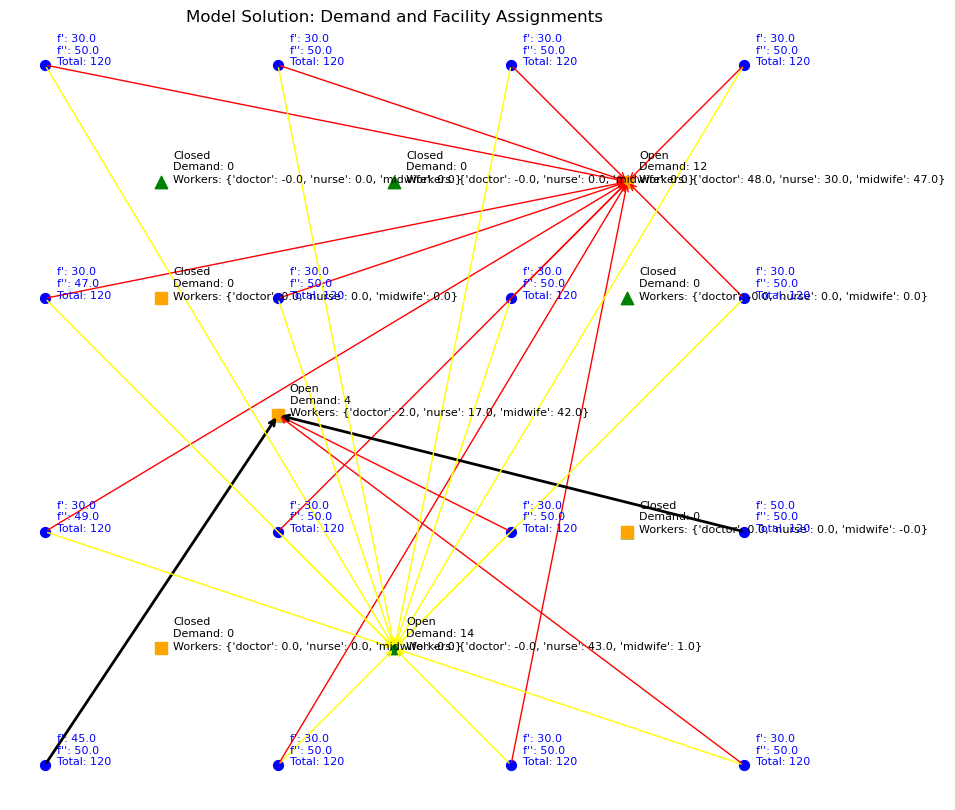

In [12]:
#%% Plot the solution

import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import LineString

def plot_solution(model, demand_points_gdf, hfs_gdf):
    """
    Visualise the solution of the Pyomo model without location names and without the surrounding box.
    
    Parameters:
        model: Solved Pyomo model
        demand_points_gdf: GeoDataFrame with demand points (geometry and labels)
        hfs_gdf: GeoDataFrame with potential locations for health posts (HP) and health centres (HC) (geometry and labels)
    """
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot demand points (without names)
    demand_points_gdf.plot(ax=ax, color='blue', markersize=50)

    # Plot HPs (triangles) and HCs (squares) without labels
    hps_gdf = hfs_gdf[hfs_gdf['label'].isin(model.J_HP)]
    hcs_gdf = hfs_gdf[hfs_gdf['label'].isin(model.J_HC)]
    hps_gdf.plot(ax=ax, color='green', marker='^', markersize=80)
    hcs_gdf.plot(ax=ax, color='orange', marker='s', markersize=80)

    # Plot assignments with arrows
    for i in model.I:
        for j in model.J:
            if model.x1[i, j].value > 0 or model.x2[i, j].value > 0:
                # Get coordinates for the demand point and facility
                dp_coords = demand_points_gdf.loc[demand_points_gdf['label'] == i, 'geometry'].values[0]
                hf_coords = hfs_gdf.loc[hfs_gdf['label'] == j, 'geometry'].values[0]

                # Determine arrow colour
                if model.x1[i, j].value > 0 and model.x2[i, j].value > 0:
                    arrow_color = 'black'
                    linewidth = 2
                elif model.x1[i, j].value > 0:
                    arrow_color = 'yellow'
                    linewidth = 1
                elif model.x2[i, j].value > 0:
                    arrow_color = 'red'
                    linewidth = 1

                ax.annotate(
                    '', xy=(hf_coords.x, hf_coords.y), xytext=(dp_coords.x, dp_coords.y),
                    arrowprops=dict(arrowstyle='->', color=arrow_color, lw=linewidth),
                    zorder=1
                )

    # Add information text for each facility (demand and workers), without the facility name
    for j in model.J:
        assigned_demand_points = sum(model.x1[i, j].value > 0 or model.x2[i, j].value > 0 for i in model.I)
        workers = {p: model.w[j, p].value for p in model.P}
        status = "Open" if sum(model.y[j, l].value for l in model.L) > 0 else "Closed"
        hf_coords = hfs_gdf.loc[hfs_gdf['label'] == j, 'geometry'].values[0]
        ax.text(
            hf_coords.x + 0.1, hf_coords.y,
            f"{status}\nDemand: {assigned_demand_points}\nWorkers: {workers}",
            fontsize=8, color='black'
        )

    # Add information text for each demand point (flows), without the demand point name
    for i in model.I:
        f1_sum = sum(model.f1[i, j, s].value for j in model.J for s in model.S)
        f2_sum = sum(model.f2[i, j, s].value for j in model.J for s in model.S)
        total_demand = sum(model.d1[i, s] + model.d2[i, s] for s in model.S)
        dp_coords = demand_points_gdf.loc[demand_points_gdf['label'] == i, 'geometry'].values[0]
        ax.text(
            dp_coords.x + 0.1, dp_coords.y,
            f"f': {f1_sum}\nf'': {f2_sum}\nTotal: {total_demand}",
            fontsize=8, color='blue'
        )

    # Remove the axes (box) for a cleaner look
    ax.set_axis_off()

    plt.title("Model Solution: Demand and Facility Assignments")
    plt.show()


# # Example usage:
print(results.solver.termination_condition)
plot_solution(model, demand_points_gdf, hfs_gdf)


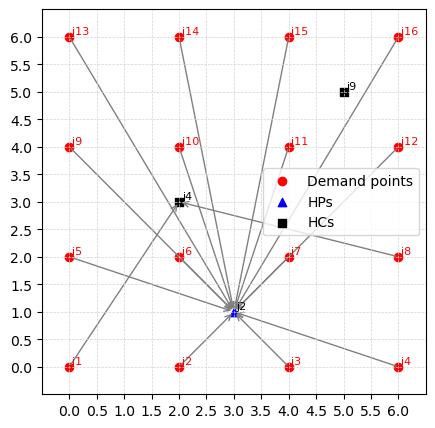

In [41]:
# Plot solution

def plot_solution_v1(model, demand_points_gdf, hfs_gdf, show_first_assignment=False, show_second_assignment=False):
    # Extract open facilities from the model
    open_facilities = {
        j: l
        for (j, l) in model.y.keys()
        if pyo.value(model.y[j, l]) > 0  # Only keep open facilities
    }
    # Open facilities GeoDataFrame
    open_hfs_gdf = hfs_gdf[hfs_gdf['label'].isin(open_facilities.keys())].copy()

    open_hfs_gdf


    # Add a column for facility type (HP or HC) based on l
    open_hfs_gdf['facility_type'] = open_hfs_gdf['label'].map(open_facilities)
    open_hfs_gdf


    # Extract first assignments from the model
    assignments1 = {
        (i, j): pyo.value(model.x1[i, j])
        for (i, j) in model.x1.keys()
        if pyo.value(model.x1[i, j]) > 0  # Only keep active first assignments
    }

    # Extract second assignments from the model
    assignments2 = {
        (i, j): pyo.value(model.x2[i, j])
        for (i, j) in model.x2.keys()
        if pyo.value(model.x2[i, j]) > 0  # Only keep active second assignments
    }

    # Create a list of connections (coordinates) for first assignment
    connections1 = [
        (
            demand_points_gdf.loc[demand_points_gdf['label'] == i, 'geometry'].values[0],  # Demand point coords
            hfs_gdf.loc[hfs_gdf['label'] == j, 'geometry'].values[0]  # Facility coords
        )
        for (i, j) in assignments1.keys()
    ]

    # Create a list of connections (coordinates) for second assignment
    connections2 = [
        (
            demand_points_gdf.loc[demand_points_gdf['label'] == i, 'geometry'].values[0],  # Demand point coords
            hfs_gdf.loc[hfs_gdf['label'] == j, 'geometry'].values[0]  # Facility coords
        )
        for (i, j) in assignments2.keys()
    ]


    fig, ax = plt.subplots(figsize=(5,5))

    # Plot the grid and demand points
    demand_points_gdf.plot(ax=ax, color='red', label='Demand points')

    # Add labels for demand points
    for idx, row in demand_points_gdf.iterrows():
        ax.text(row.geometry.x + 0.05, row.geometry.y + 0.05, row['label'], fontsize=8, color='red')


    # Plot open HPs and HCs separately
    hps_open_gdf = open_hfs_gdf[open_hfs_gdf['facility_type'] == 'hp']
    hcs_open_gdf = open_hfs_gdf[open_hfs_gdf['facility_type'] == 'hc']

    hps_open_gdf.plot(ax=ax, color='blue', marker='^', label='HPs')
    hcs_open_gdf.plot(ax=ax, color='black', marker='s',label='HCs')

    # Add labels for open facilities
    for idx, row in open_hfs_gdf.iterrows():
        ax.text(row.geometry.x + 0.05, row.geometry.y + 0.05, row['label'], fontsize=8, color='black')

    
    # Conditionally add first assignment arrows
    if show_first_assignment:
        for (start, end) in connections1:
            ax.annotate(
                '', xy=(end.x, end.y), xytext=(start.x, start.y),
                arrowprops=dict(arrowstyle='->', color='gray', lw=1),
                zorder=1
            )

    # Conditionally add second assignment arrows
    if show_second_assignment:
        for (start, end) in connections2:
            ax.annotate(
                '', xy=(end.x, end.y), xytext=(start.x, start.y),
                arrowprops=dict(arrowstyle='->', color='orange', lw=1),
                zorder=1
            )

    # Set axis limits based on your grid dimensions (6x6)
    ax.set_xlim(-0.5, 6.5)
    ax.set_ylim(-0.5, 6.5)

    # Add gridlines at every 0.5 unit
    ax.set_xticks([x * 0.5 for x in range(13)])  # From 0 to 6 with a step of 0.5
    ax.set_yticks([y * 0.5 for y in range(13)])
    ax.grid(color='lightgray', linestyle='--', linewidth=0.5)

    # Add legend and show plot
    ax.legend()
    #plt.title("Location-Allocation Solution with Grid")

    plt.show()

plot_solution_v1(model, demand_points_gdf, hfs_gdf, show_first_assignment=True, show_second_assignment=False)

In [40]:
# Display only the selected variables
print("Selected variables (y_jl = 1, x1_ij = 1, x2_ij = 1, f1_ijs > 0, f2_ijs > 0, w_jp > 0, taumax > 0, deltamax > 0):")
for j in model.J:
        for l in model.L:
            if model.y[j, l].value is not None and model.y[j, l].value > 0:
                print(f"y[{j},{l}] = {model.y[j, l].value}")
for i in model.I:
        for j in model.J:
                if model.x1[i, j].value is not None and model.x1[i, j].value > 0:
                    print(f"x1[{i},{j}] = {model.x1[i, j].value}") 
for i in model.I:
        for j in model.J:
                if model.x2[i, j].value is not None and model.x2[i, j].value > 0:
                    print(f"x2[{i},{j}] = {model.x2[i, j].value}") 
for i in model.I:
        for j in model.J:
            for s in model.S:
                if model.f1[i, j, s].value is not None and model.f1[i, j, s].value > 0:
                    print(f"f1[{i},{j},{s}] = {model.f1[i, j, s].value}") 
for i in model.I:
        for j in model.J:
            for s in model.S:
                if model.f2[i, j, s].value is not None and model.f2[i, j, s].value > 0:
                    print(f"f2[{i},{j},{s}] = {model.f2[i, j, s].value}") 
for j in model.J:
        for p in model.P:
                if model.w[j, p].value is not None and model.w[j, p].value > 0:
                    print(f"w[{j},{p}] = {model.w[j, p].value}") 
if model.taumax.value is not None and model.taumax.value > 0:
    print(f"taumax = {model.taumax.value}") 
if model.deltamax.value is not None and model.deltamax.value > 0:
    print(f"deltamax = {model.deltamax.value}") 
    


Selected variables (y_jl = 1, x1_ij = 1, x2_ij = 1, f1_ijs > 0, f2_ijs > 0, w_jp > 0, taumax > 0, deltamax > 0):
y[j2,hp] = 1.0
y[j4,hc] = 1.0
y[j9,hc] = 1.0
x1[i1,j4] = 1.0
x1[i2,j2] = 1.0
x1[i3,j2] = 1.0
x1[i4,j2] = 1.0
x1[i5,j2] = 1.0
x1[i6,j2] = 1.0
x1[i7,j2] = 1.0
x1[i8,j4] = 1.0
x1[i9,j2] = 1.0
x1[i10,j2] = 1.0
x1[i11,j2] = 1.0
x1[i12,j2] = 1.0
x1[i13,j2] = 1.0
x1[i14,j2] = 1.0
x1[i15,j2] = 1.0
x1[i16,j2] = 1.0
x2[i1,j4] = 1.0
x2[i2,j9] = 1.0
x2[i3,j9] = 1.0
x2[i4,j4] = 1.0
x2[i5,j9] = 1.0
x2[i6,j9] = 1.0
x2[i7,j4] = 1.0
x2[i8,j4] = 1.0
x2[i9,j9] = 1.0
x2[i10,j9] = 1.0
x2[i11,j9] = 1.0
x2[i12,j9] = 1.0
x2[i13,j9] = 1.0
x2[i14,j9] = 1.0
x2[i15,j9] = 1.0
x2[i16,j9] = 1.0
f1[i1,j4,maternal1] = 20.0
f1[i1,j4,maternal2] = 25.0
f1[i2,j2,basic] = 10.0
f1[i2,j2,maternal1] = 20.0
f1[i3,j2,basic] = 10.0
f1[i3,j2,maternal1] = 20.0
f1[i4,j2,basic] = 10.0
f1[i4,j2,maternal1] = 20.0
f1[i5,j2,basic] = 10.0
f1[i5,j2,maternal1] = 20.0
f1[i6,j2,basic] = 10.0
f1[i6,j2,maternal1] = 20.0
f1[i7,j2,bas

In [23]:

#%% Create Summary table
import pandas as pd

rows = []

for j in model.J:
    # Determine if facility j is open by checking if any y[j,l] > 0.
    facility_type = None
    for l in model.L:
        if model.y[j, l].value is not None and model.y[j, l].value > 0:
            facility_type = l
            break  # Only one type is assigned per facility.
    if facility_type is None:
        continue  # Skip facilities that are not open.

    # --- Satisfied Demand: compute f1 and f2 sums per service ---
    f1_sums = {}
    f2_sums = {}
    for s in model.S:
        f1_total = 0
        f2_total = 0
        for i in model.I:
            f1_val = model.f1[i, j, s].value if model.f1[i, j, s].value is not None else 0
            f2_val = model.f2[i, j, s].value if model.f2[i, j, s].value is not None else 0
            f1_total += f1_val
            f2_total += f2_val
        f1_sums[s] = f1_total
        f2_sums[s] = f2_total

    overall_f1 = sum(f1_sums[s] for s in model.S)
    overall_f2 = sum(f2_sums[s] for s in model.S)
    overall_satisfied = overall_f1 + overall_f2

    # --- Total Demand Assigned: compute d1 and d2 sums per service ---
    assigned_demand_d1 = {}
    assigned_demand_d2 = {}
    for s in model.S:
        total_d1 = 0
        total_d2 = 0
        for i in model.I:
            d1_val = model.d1[i, s] if model.d1[i, s] is not None else 0
            d2_val = model.d2[i, s] if model.d2[i, s] is not None else 0
            x1_val = model.x1[i, j].value if model.x1[i, j].value is not None else 0
            x2_val = model.x2[i, j].value if model.x2[i, j].value is not None else 0
            total_d1 += d1_val * x1_val
            total_d2 += d2_val * x2_val
        assigned_demand_d1[s] = total_d1
        assigned_demand_d2[s] = total_d2

    overall_d1 = sum(assigned_demand_d1[s] for s in model.S)
    overall_d2 = sum(assigned_demand_d2[s] for s in model.S)
    overall_assigned = overall_d1 + overall_d2

    # --- Compute capacity per service (number of services available) ---
    capacity_per_service = {}
    for s in model.S:
        available_time = 0
        for p in model.P:
            w_val = model.w[j, p].value if model.w[j, p].value is not None else 0
            available_time += model.c[p] * model.a_W[p, s] * w_val
        service_time = q[s]
        capacity = int(available_time / service_time) if service_time > 0 else 0
        capacity_per_service[s] = capacity

    # --- Compute Efficiency as (overall satisfied)/(overall assigned) ---
    efficiency = overall_satisfied / overall_assigned if overall_assigned > 0 else None

    # --- Compute new Utilization (Service/Personnel) ---
    # Total service time provided = sum_{s in S} ( (f1_s + f2_s) * q[s] )
    total_service_time = sum((f1_sums[s] + f2_sums[s]) * q[s] for s in model.S)
    # Total personnel time = sum_{p in P} (w[j,p] * c[p])
    total_personnel_time = 0
    for p in model.P:
        personnel = model.w[j, p].value if model.w[j, p].value is not None else 0
        total_personnel_time += personnel * model.c[p]
    new_utilization = total_service_time / total_personnel_time if total_personnel_time > 0 else None

    # --- Compute maximum distance from facility j to any assigned demand point ---
    assigned_distances = []
    for i in model.I:
        if ((model.x1[i, j].value is not None and model.x1[i, j].value > 0) or 
            (model.x2[i, j].value is not None and model.x2[i, j].value > 0)):
            assigned_distances.append(model.t[i, j])
    max_distance = max(assigned_distances) if assigned_distances else 0

    # --- Build the row for facility j ---
    row = {
        "Facility": j,
        "Type": facility_type,
        "Satisfied Demand": f"{overall_f1},{overall_f2}",
        "Total Demand": f"{overall_d1},{overall_d2}",
        "Efficiency (%)": f"{efficiency*100:.1f}%" if efficiency is not None else "N/A",
        "Utilization (Service/Personnel)": f"{new_utilization*100:.1f}%" if new_utilization is not None else "N/A",
        "Max Distance": max_distance
    }
    
    # For each service, show satisfied demand as "f1,f2 (Capacity)"
    for s in model.S:
        row[f"Demand_{s}"] = f"{f1_sums[s]},{f2_sums[s]} ({capacity_per_service[s]})"
    
    # Add personnel columns (as integers)
    for p in model.P:
        personnel = model.w[j, p].value
        personnel_int = int(personnel) if personnel is not None else 0
        row[f"Personnel_{p}"] = personnel_int
    
    rows.append(row)

# Create a DataFrame from the collected rows.
summary_table = pd.DataFrame(rows)

# --- Enhance headers for managerial insight ---
header_mapping = {
    "Facility": "Facility ID",
    "Type": "Facility Type",
    "Satisfied Demand": "Satisfied Demand (f1,f2)",
    "Total Demand": "Total Demand (d1,d2)",
    "Efficiency (%)": "Efficiency (%)",
    "Utilization (Service/Personnel)": "Utilization (Service/Personnel)",
    "Max Distance": "Max Distance"
}
for s in model.S:
    header_mapping[f"Demand_{s}"] = f"Demand - {s.capitalize()} (Capacity)"
for p in model.P:
    header_mapping[f"Personnel_{p}"] = f"Personnel - {p.capitalize()}"

summary_table.rename(columns=header_mapping, inplace=True)

# --- Define a helper function for conditional formatting ---
def highlight_diff(val):
    try:
        # Expecting format like "a,b (cap)" or "number (cap)"
        left, right = val.split('(')
        left = left.strip()
        capacity_val = int(right.split(')')[0].strip())
        if ',' in left:
            parts = left.split(',')
            demand_val = sum(int(x.strip()) for x in parts)
        else:
            demand_val = int(left)
        diff = capacity_val - demand_val
        if diff < 0:
            return 'background-color: salmon'   # Demand exceeds capacity.
        elif diff > 0:
            return 'background-color: lightgreen'  # Spare capacity available.
        else:
            return ''
    except Exception:
        return ''

# --- Apply Pandas styling (to output as HTML) ---
styled_table = summary_table.style.set_table_styles([
    {'selector': 'th',
     'props': [('background-color', '#4F81BD'),
               ('color', 'white'),
               ('font-size', '12pt'),
               ('text-align', 'center'),
               ('padding', '8px')]}
]).set_properties(**{'text-align': 'center', 'font-size': '11pt'})

# Apply conditional formatting on the per-service demand columns.
for col in summary_table.columns:
    if "Demand - " in col:
        styled_table = styled_table.map(highlight_diff, subset=[col])

styled_table = styled_table.set_caption("Facility Summary Table - Managerial Insights")

# --- Save the styled table as an HTML file (openable in any browser) ---
html = styled_table.to_html()
with open("facility_summary_improved.html", "w") as f:
    f.write(html)
print("Summary table saved as 'facility_summary_improved.html'.")

# Optionally, export the raw table to CSV and Excel.
# summary_table.to_csv("facility_summary_improved.csv", index=False)
# summary_table.to_excel("facility_summary_improved.xlsx", index=False)


Summary table saved as 'facility_summary_improved.html'.
